In [ ]:
# coding=utf-8
# Copyright 2023 Frank Latos AC8P
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#
# Much appreciation to the Pymoo project for providing the optimization framework used herein:
#
# pymoo: Multi-objective Optimization in Python
# https://github.com/anyoptimization/pymoo
# https://pymoo.org/index.html
#


# Broadband 80 Meter Antenna Ideas (GPU Version)

This is the same code as in the previous notebook, but with the search for the optimum series-section-matching parameters moved to the GPU.

Observe relative speed, confirm that results are identical.


Conclusion: the GPU version of the simulation executes in 23.0 seconds on my workstation, versus 150 seconds for the original version, with identical results.

In [3]:

import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from necutil import nec5_sim_stdio3, make_linear_element, gen_nec5_str, plot_vswr_2
from necutil import wire_ant_visualize, rot_x, rot_y, translate, make_cage_element, total_wire_len
from necutil import series_match_precompute, series_match_scan

import jax.numpy as jnp
from jax import grad, jit, vmap, device_put


@jit
def series_match_scan_jax(zr, A,B,C,D, z0):
    zt = (zr*A + B) / ((1j)*zr*C + D)                   # Transformed impedances for all segment length combinations
    refl_coef = jnp.abs((zt - z0) / (zt + z0))
    vswr = (1 + refl_coef) / (1 - refl_coef)
    max_vswr = jnp.max(vswr, axis=-1)

    idx = jnp.argmin(max_vswr)                          # Flat index
    a,b = jnp.unravel_index(idx, max_vswr.shape)        # Convert to original indices
    return jnp.array((a, b)), vswr[a,b], jnp.array([max_vswr[a,b]])




class DipoleSSMProblem(Problem):
    # n_var, n_obj, n_ieq_constraints       #variables (design parameters), #objectives, #inequality constraints
    # segs_per_m                            segments per meter when generating NEC cards
    # radius, z                             wire radius (m), height above ground (m)
    # f_min, f_max, f_num                   freq band of interest, #freq points within band
    # z0a, z0b                              impedances of series-section-matching TLs
    def __init__(self, n_var, n_obj, n_ieq_constr, segs_per_m, radius, f_min, f_max, z, f_num=9, z0a=50, z0b=75, **kwargs):
        super().__init__(n_var=n_var,
                         n_obj=n_obj,
                         n_ieq_constr=n_ieq_constr,
                         **kwargs)

        # Save some problem characteristics
        self.f_min = f_min              # Frequency band of interest: min, max, # of points
        self.f_max = f_max
        self.f_num = f_num        
        self.freqs = np.linspace(f_min, f_max, num=f_num)       # Freqs of interest as an array
        self.f_center = np.mean([f_min,f_max])                  # Center freq
        self.z0 = 50                    # TL impedance
        self.z = z                      # z dimension (height of antenna)
        self.segs_per_m = segs_per_m    # NEC segments per meter 
        self.radius = radius            # Wire radius (m)

        # Precompute some arrays (speeds process of scanning for optimum matching network)
        A,B,C,D = series_match_precompute(zoa=z0a,zob=z0b,nfreq=f_num,flow=f_min,fhigh=f_max)

        # ******** Move arrays to GPU ********
        self.A = device_put(A)
        self.B = device_put(B)
        self.C = device_put(C)
        self.D = device_put(D)
        # ******** Move arrays to GPU ********


        # NEC5 design deck template
        # GX: mirror across xz plane
        # EX: feedpoint specified as tag=1, segment=1, near end (1)
        # GD: Some typical MININEC ground parameters
        self.necpre = 'CE Dipole\n'             # Obligatory comment line
        self.necpost = f"""GX 100 010
GE 1 0
GD 0 0 0 0 13 0.005 0 0
EX 4 1 1 1 1.0 0.0
FR 0 {f_num} 0 0 {f_min} {(f_max-f_min)/(f_num-1)}
XQ 0
EN
"""
 
    

    # Optimization algorithms call this entry point with a population of designs
    #   X       an array of design parameters of shape (population_size, number_of_variables)
    #   out     dictionary where we'll return our results
    def _evaluate(self, X, out, *args, **kwargs):

        # Write a custom _make_design() for your problem
        # Use the params in x to create the design as a list of numpy arrays (see details in '010_Wire_Antennas.ipynb')
        designs = [self._make_design(x) for x in X]                 # Make antenna designs based on params in X

        # Turns your design into an NEC deck using the template
        necdecks = [self.necpre + gen_nec5_str(d, self.segs_per_m, self.radius) + self.necpost for d in designs]     # Convert to NEC decks (strings)

        res = nec5_sim_stdio3(necdecks, timelimit=10000.0)          # Run the simulations

        # Extracts feedpoint complex z for each design --> complex array of shape (#designs, #freqs)
        zs = np.array([[freq[1] for freq in des[0][0]] for des in res])

        # Scan for optimum series matching segment lengths (degrees) for each design
        # We're checking all lengths of [0, 180] degrees for both z0a, z0b segments
        # a_b = np.empty((zs.shape[0],2))
        # vswr_curves = np.empty(zs.shape)
        # max_vswr = np.empty((zs.shape[0],1))
        # for idx in range(zs.shape[0]):
        #     aopt,bopt,vswr_curve_opt,vswr_max_opt = series_match_scan(zs[idx:idx+1], self.A,self.B,self.C,self.D, z0=self.z0)
        #     a_b[idx,:] = (aopt,bopt)
        #     vswr_curves[idx,:] = vswr_curve_opt
        #     max_vswr[idx,:] = vswr_max_opt

        # ******** Runs the previous code block on the GPU ********
        # The 100 or 200 designs are evaluated in parallel...
        a_b,vswr_curves,max_vswr = vmap(series_match_scan_jax, (0,None,None,None,None,None))(zs, self.A,self.B,self.C,self.D, 50)
        # *********************************************************


        # Write a custom function to return objectives, constraints, other values
        self._compute_results(X, out, designs, zs, a_b, vswr_curves, max_vswr)



# A simple linear scaling class:
#  We want to scale our objectives to be of similar sizes
class ObjectiveScaler:
    def __init__(self,xl,xh,scaledl,scaledh):
        self.m = (scaledh-scaledl)/(xh-xl)
        self.b = scaledl - self.m*xl
    def scale(self, X):
        return self.m*X + self.b
    def unscale(self, X):
        return (X - self.b) / self.m
    

#
# The class representing our specific problem
#
class OptCageSSMProblem(DipoleSSMProblem):
    # (2) variables:  overall length (of half-element), length of 'cage' portion (as fraction of element length)
    # (2) objectives to minimize: max VSWR within band, total wire length used
    # (1) constraint: max vswr <= 2.0
    def __init__(self, **kwargs):
        super().__init__(n_var=2, n_obj=2, n_ieq_constr=1, **kwargs)

        # Create scaler objs to scale our objectives to approx [0.0, 1.0] ranges
        self.vswr_scaler = ObjectiveScaler(1.0, 2.0, 0.0, 1.0)          # VSWRs from 1.0 - 2.0
        self.wlen_scaler = ObjectiveScaler(20.0, 40.0, 0.0, 1.0)        # Range of wire lengths 20 - 40m (?)


    # Your custom function to construct the antenna
    # See '010_Wire_Antennas.ipynb' for more details
    # Design params: 
    #   x[0]    overall length
    #   x[1]    length of 'cage' portion as fraction of overall length
    def _make_design(self, x):
        half_el = make_linear_element((0,0,0),(0,0.5,0))                        # Initial 0.5m straight wire section
        half_el.extend( make_cage_element(0.5, x[0]*x[1]+0.5, .2, .5, 2) )      # 2 wires, 1m apart
        half_el.extend( make_linear_element((0,x[0]*x[1]+0.5,0),(0,x[0],0)) )   # Straight wire for remainder of element
        half_el = rot_y(half_el, np.pi/2)               # Rotate 90deg so wires are in horizontal plane
        half_el = translate(half_el, (0,0,self.z))      # Move to 'z' meters above ground
        return half_el


    # Your custom function to return objectives, constraints, other values
    def _compute_results(self, X, out, designs, zs, a_b, vswr_curves, max_vswr):

        #
        # Our objectives to minimize are:  max vswr in band, total wire length used
        #
        total_wl =  np.array([total_wire_len(des) for des in designs])[:,None]      # Wire lengths as column vector
        out['F'] = [self.vswr_scaler.scale(max_vswr), self.wlen_scaler.scale(total_wl)]         # Return objs as a list of column vectors

        # Constraint: max vswr must be <= 2.0
        out['G'] = max_vswr - 2.0               # Constraint satisfied if <= 0
        
        # Can attach any other data to population of designs
        #  Not used in optimization, but can be examined later...
        out['VSWR'] = vswr_curves               # VSWR values across freq band
        out['AB'] = a_b                         # Lengths (degrees) of 'z0a' and 'z0b' matching sections
        


AWG14RADIUS = 1.628/1000/2              # 1.628mm dia
SEGS_PER_M = 10/20.0                    # NEC segments: around 10 for the half-element
ocproblem = OptCageSSMProblem(f_min=3.5, f_max=4.0, z=30,
                                segs_per_m=SEGS_PER_M, radius=AWG14RADIUS,
                                xl=np.array([17.0, 0.1]),                   # Lower, upper limits of parameters:
                                xu=np.array([23.0, 1.0]))                   # Overall len [17.0, 23.0], cage fraction [0.1, 1.0]
# Pymoo provides a variety of termination conditions
# For simplicity's sake we will just run for 50 generations
termination = get_termination("n_gen", 50)  

# Algorithm: Multi-objective genetic algorithm
algorithm = NSGA2(pop_size=200, n_offsprings=100)
# Run
res = minimize(ocproblem, algorithm, termination, save_history=False, verbose=True)




n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      200 |      8 |  0.000000E+00 |           nan |             - |             -
     2 |      300 |     11 |  0.000000E+00 |  0.6572940016 |  0.0257825871 |             f
     3 |      400 |     13 |  0.000000E+00 |  0.1359467757 |  0.0147567006 |             f
     4 |      500 |     14 |  0.000000E+00 |  0.0082418096 |  0.0095040178 |         ideal
     5 |      600 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0069056477 |             f
     6 |      700 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0158197239 |         nadir
     7 |      800 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0082706941 |             f
     8 |      900 |     29 |  0.000000E+00 |  0.000000E+00 |  0.0073880654 |             f
     9 |     1000 |     32 |  0.000000E+00 |  0.000000E+00 |  0.0023406806 |             f
    10 |     1100 |     38 |  0.000000E+00 |  0.000000E+00 |  0.0077229335 |             f

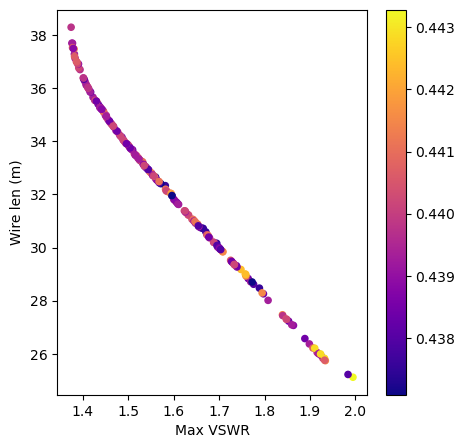

In [153]:
#
# Create a plot showing max-vswr vs. total-wire-length tradeoff
# Color scale = total loss in matching lines (dB)
#

# Un-scale the objective values
max_vswr = ocproblem.vswr_scaler.unscale(res.F[:,0:1])
total_wl = ocproblem.wlen_scaler.unscale(res.F[:,1:2])

# Compute total matching network loss (dB) (although it doesn't vary much in this problem...)
tl_loss = np.sum(res.pop.get('AB') * (299.792458 / 3.75 / 360.0) * np.array([[0.66, 0.82]]) * np.array([[1.233/100, 0.737/100]]), axis=1)[:,None]
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
pts = ax.scatter(max_vswr, total_wl, c=tl_loss, s=20, cmap='plasma')

ax.set_xlabel('Max VSWR')
ax.set_ylabel('Wire len (m)')
fig.colorbar(pts)
plt.show()


In [154]:
#
# Look at detailed results as a data frame
#
import pandas as pd
df = pd.DataFrame(np.hstack([res.X, max_vswr, total_wl, tl_loss, res.pop.get('AB')]),
                   columns=['Overall len (m)', 'Cage fraction', 'Max VSWR','Wire Len (m)', 'Loss (dB)', 'A (deg)', 'B (deg)'])
df

,Overall len (m),Cage fraction,Max VSWR,Wire Len (m),Loss (dB),A (deg),B (deg)
0,19.822746,0.863355,1.374546,38.290887,0.439773,178.0,88.0
1,20.603284,0.153477,1.994500,25.119479,0.443281,174.0,96.0
2,20.661542,0.155263,1.983697,25.223574,0.438019,180.0,84.0
3,21.268585,0.253428,1.807837,28.012699,0.439308,177.0,89.0
4,20.762492,0.174642,1.933801,25.742565,0.441527,176.0,92.0
...,...,...,...,...,...,...,...
195,21.898196,0.535137,1.451782,34.970798,0.439773,178.0,88.0
196,21.961130,0.444712,1.535442,33.081578,0.440185,176.0,91.0
197,21.891100,0.533962,1.452071,34.934190,0.439308,177.0,89.0
198,21.544178,0.625721,1.401962,36.378885,0.439773,178.0,88.0


Overall len (m)     21.883848
Cage fraction        0.391939
Max VSWR             1.600257
Wire Len (m)        31.815041
Loss (dB)            0.440185
A (deg)            176.000000
B (deg)             91.000000
Name: 58, dtype: float64


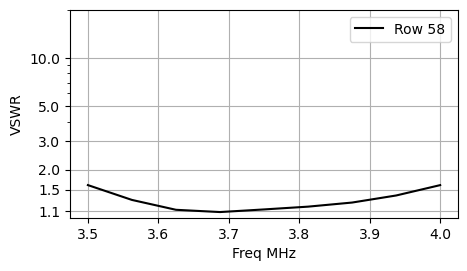

In [157]:
# Find design with max vswr closest to 1.60
row = np.argmin(np.abs(df['Max VSWR'] - 1.60))
print(df.iloc[row])

fvpairs = list(zip(ocproblem.freqs, res.pop.get('VSWR')[row]))   # Combine frequencies and VSWR values
plot_vswr_2([fvpairs], tags=[f'Row {row}'])